In [11]:
# from datetime import timedelta
import cv2
import numpy as np
import os
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from icecream import ic

import torch
import torchvision.transforms as transforms

## some util
def print_img_stats(*imgs):
    for img in imgs:
        print(img.shape, img.min(), img.max())
        
def load_uint8_img(img_path):
    """load img as uint8"""
    img = plt.imread(img_path)
    if img.max() < 100: # float
        img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    else:
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img

In [2]:
# import torchvision.io as io

# ok = io.read_image("/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/IMG_2151/2252.jpg")


In [3]:
import torch
torch.__version__

'1.13.1'

In [4]:
import sys
print(sys.executable)

/Users/jameschen/opt/anaconda3/envs/capstone/bin/python


## Segment black

### util

In [2]:
def plot_np_image_grid(img_list, n_per_row=7, titles=None, gray=[], figsize=(15,10)):
    """
    torchvision make_grid (via plt.subplots+untransform)
    + title 
    + figsize
    (can add plt.suptitle outside)

    args:
    img_list: list of img as tensor
    """
    assert len(img_list) > 0
    if titles:
        assert len(img_list) == len(titles)
    n_row = (len(img_list)-1) // n_per_row + 1
    fig, axes = plt.subplots(n_row, n_per_row, figsize=figsize, 
                            squeeze=False, constrained_layout=True)
    for i, img in enumerate(img_list):
        if i in gray:
            axes[i//n_per_row, i%n_per_row].imshow(img, cmap="gray")
        else:
            axes[i//n_per_row, i%n_per_row].imshow(img)
        axes[i//n_per_row, i%n_per_row].axis("off")
        if titles:
            axes[i//n_per_row, i%n_per_row].set_title(titles[i])
    for i in range(len(img_list), n_row*n_per_row):
        axes[i//n_per_row, i%n_per_row].axis("off")

### Segment black bg

(1920, 1080, 3) 0 255


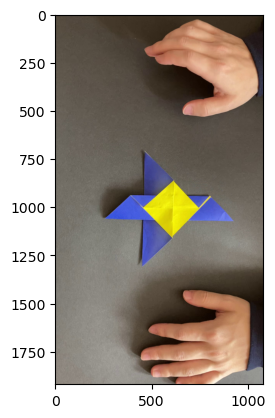

In [7]:
img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/IMG_2151/2252.jpg"
img = plt.imread(img_path) #/255).astype(np.float32)
print(img.shape, img.min(), img.max())
plt.imshow(img)
plt.show()

(720, 1280, 3) 0 250


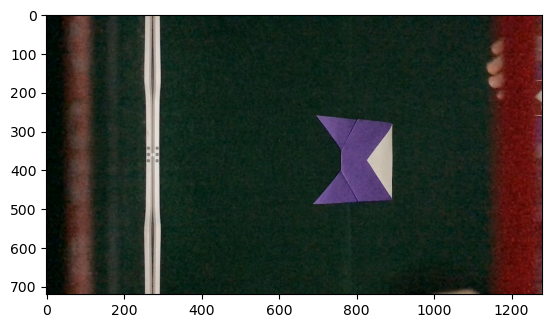

In [7]:
img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/5342.jpg"
img = load_uint8_img(img_path) #/255).astype(np.float32)
print_img_stats(img)
plt.imshow(img)
plt.show()

(720, 1280) 0 244
(720, 1280) 102 255
(720, 1280) 5 255


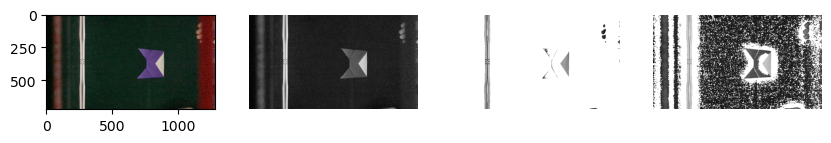

In [9]:
## manual threshold
scale = 255
THRESHOLD = 0.4 * scale

n = 4
plt.figure(figsize=(10,8))
plt.subplot(1,n,1)
plt.imshow(img)

gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
print(gray_img.shape, gray_img.min(), gray_img.max())
plt.subplot(1,n,2)
plt.axis("off")
plt.imshow(gray_img, cmap="gray")

gray_img2 = gray_img.copy()
gray_img2[gray_img2 < THRESHOLD] = scale
print(gray_img2.shape, gray_img2.min(), gray_img2.max())
plt.subplot(1,n,3)
plt.axis("off")
plt.imshow(gray_img2, cmap="gray")

gray_img3 = gray_img.copy()
thr = cv2.adaptiveThreshold(gray_img3, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                            cv2.THRESH_BINARY_INV, 201, 4)
gray_img3[thr.astype(bool)] = 255
print(gray_img3.shape, gray_img3.min(), gray_img3.max())
plt.subplot(1,n,4)
plt.axis("off")
plt.imshow(gray_img3, cmap="gray")

plt.show()

try using threshold on different channels

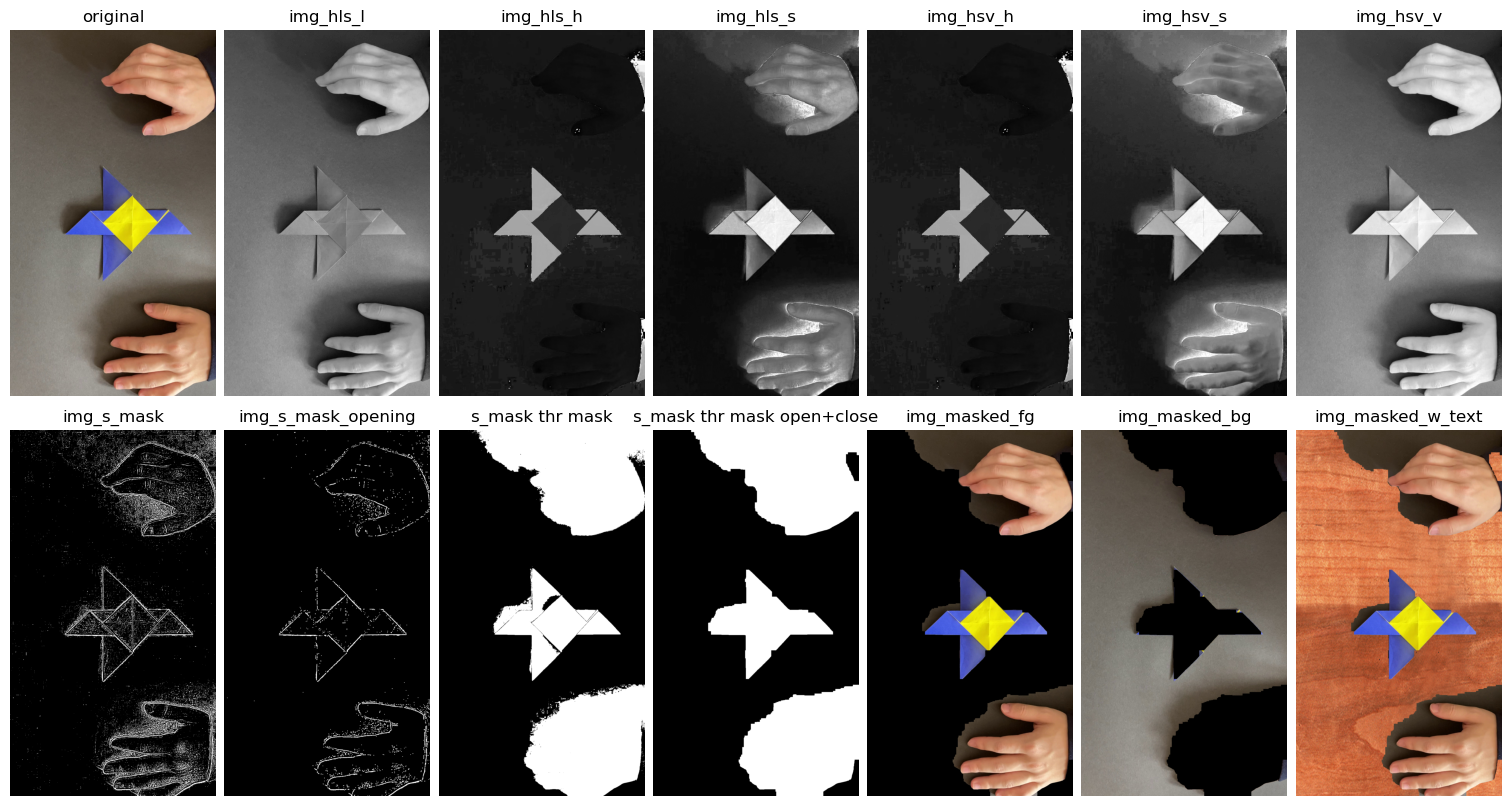

In [14]:
img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project code/Code/data/IMG_2151/2257.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/5342.jpg"
img = load_uint8_img(img_path) #/255).astype(np.float32)

img_list = [img]
gray = []
titles = ["original"]

# into HLS
img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS_FULL)
img_hls_l = img_hls[:,:,1]
img_list.append(img_hls_l)
gray.append(len(img_list)-1)
titles.append("img_hls_l")

img_hls_h = img_hls[:,:,0]
img_list.append(img_hls_h)
gray.append(len(img_list)-1)
titles.append("img_hls_h")

img_hls_s = img_hls[:,:,2]
img_list.append(img_hls_s)
gray.append(len(img_list)-1)
titles.append("img_hls_s")

# into HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL)
img_hsv_h = img_hsv[:,:,0]
img_list.append(img_hsv_h)
gray.append(len(img_list)-1)
titles.append("img_hsv_h")

img_hsv_s = img_hsv[:,:,1]
img_list.append(img_hsv_s)
gray.append(len(img_list)-1)
titles.append("img_hsv_s")

img_hsv_v = img_hsv[:,:,2]
img_list.append(img_hsv_v)
gray.append(len(img_list)-1)
titles.append("img_hsv_v")

## use adaptiveThreshold
img_s_mask = img.copy()
img_s_mask_thr = cv2.adaptiveThreshold(img_hls_s, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 3)
img_s_mask_thr = img_s_mask_thr*255
# img_s_mask[thr.astype(bool)] = 0
# img_list.append(img_s_mask)
# titles.append("img_s_mask")
img_list.append(img_s_mask_thr)
gray.append(len(img_list)-1)
titles.append("img_s_mask")

# morphing
kernel = np.ones((3,3),np.uint8)
img_s_mask_opening = cv2.morphologyEx(img_s_mask_thr, cv2.MORPH_OPEN, kernel)
img_list.append(img_s_mask_opening)
gray.append(len(img_list)-1)
titles.append("img_s_mask_opening")

# direct threshold

img_hls_s_threshold = 0.2 * 255
mask = img_hls_s < img_hls_s_threshold

s_mask = (~mask).astype(np.uint8)*255
img_list.append(s_mask)
gray.append(len(img_list)-1)
titles.append("s_mask thr mask")

s_mask_opening = cv2.morphologyEx(s_mask, cv2.MORPH_OPEN, kernel=np.ones((15,15),np.uint8))
s_mask_opening = cv2.morphologyEx(s_mask_opening, cv2.MORPH_CLOSE, kernel=np.ones((45,45),np.uint8))
img_list.append(s_mask_opening)
gray.append(len(img_list)-1)
titles.append("s_mask thr mask open+close")

img_masked_fg = img.copy()
img_masked_fg[~(s_mask_opening).astype(bool)] = 0
img_list.append(img_masked_fg)
titles.append("img_masked_fg")

img_masked_bg = img.copy()
img_masked_bg[s_mask_opening.astype(bool)] = 0
img_list.append(img_masked_bg)
titles.append("img_masked_bg")

texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project code/Code/data/texture_dataset/Pixar128 Library/wood/American_cherry_pxr128.tif"
texture_img = plt.imread(texture_path)
texture_img = cv2.resize(texture_img, img.shape[:2], interpolation=cv2.INTER_LANCZOS4)
texture_img = texture_img.transpose(1,0,2)
img_masked_w_text = img.copy()
img_masked_w_text[~ s_mask_opening.astype(bool)] = texture_img[~ s_mask_opening.astype(bool)]
img_list.append(img_masked_w_text)
titles.append("img_masked_w_text")

plot_np_image_grid(img_list, n_per_row=7, titles=titles, gray=gray, figsize=(15,8))
plt.show()

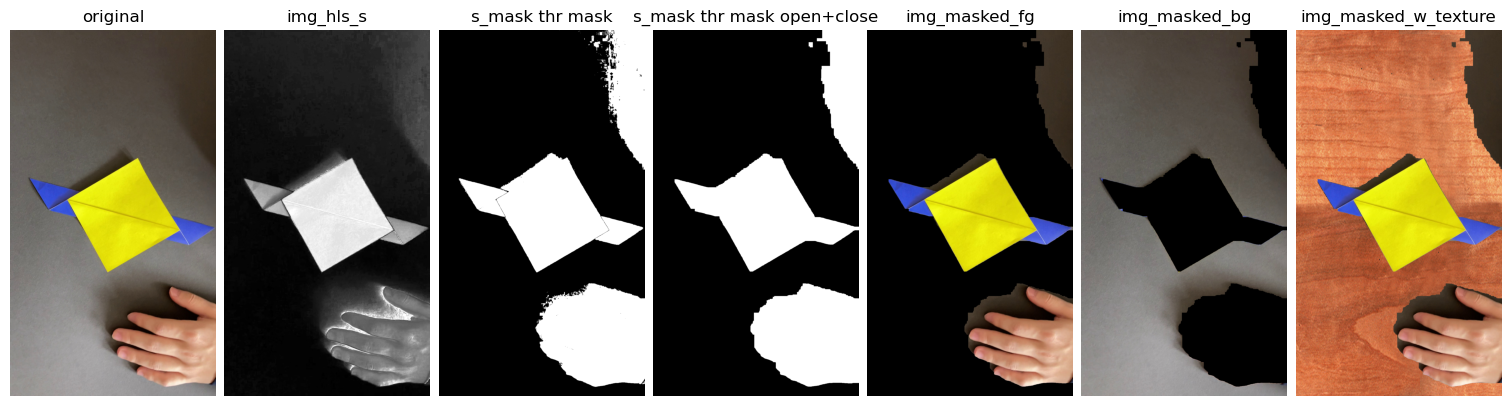

In [116]:
# result
img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/IMG_2151/1257.jpg"
img = plt.imread(img_path) #/255).astype(np.float32)

img_list = [img]
gray = []
titles = ["original"]

# into HLS
img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS_FULL)

img_hls_s = img_hls[:,:,2]
img_list.append(img_hls_s)
gray.append(len(img_list)-1)
titles.append("img_hls_s")


# direct threshold
img_hls_s_threshold = 0.2 * 255
mask = img_hls_s < img_hls_s_threshold

s_mask = (~mask).astype(np.uint8)*255
img_list.append(s_mask)
gray.append(len(img_list)-1)
titles.append("s_mask thr mask")

s_mask_opening = cv2.morphologyEx(s_mask, cv2.MORPH_OPEN, kernel=np.ones((15,15),np.uint8))
s_mask_opening = cv2.morphologyEx(s_mask_opening, cv2.MORPH_CLOSE, kernel=np.ones((45,45),np.uint8))
img_list.append(s_mask_opening)
gray.append(len(img_list)-1)
titles.append("s_mask thr mask open+close")

img_masked_fg = img.copy()
img_masked_fg[~(s_mask_opening).astype(bool)] = 0
img_list.append(img_masked_fg)
titles.append("img_masked_fg")

img_masked_bg = img.copy()
img_masked_bg[s_mask_opening.astype(bool)] = 0
img_list.append(img_masked_bg)
titles.append("img_masked_bg")

texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/Pixar128 Library/wood/American_cherry_pxr128.tif"
texture_img = plt.imread(texture_path)
texture_img = cv2.resize(texture_img, img.shape[:2], interpolation=cv2.INTER_LANCZOS4)
texture_img = texture_img.transpose(1,0,2)
img_masked_w_text = img.copy()
img_masked_w_text[~ s_mask_opening.astype(bool)] = texture_img[~ s_mask_opening.astype(bool)]
img_list.append(img_masked_w_text)
titles.append("img_masked_w_texture")

plot_np_image_grid(img_list, n_per_row=7, titles=titles, gray=gray, figsize=(15,8))
plt.show()

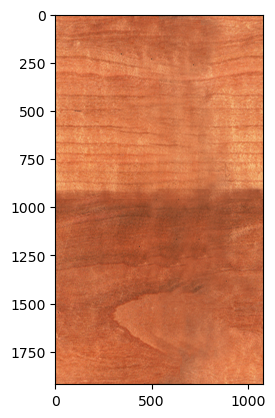

In [101]:
texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/Pixar128 Library/wood/American_cherry_pxr128.tif"
texture_img = plt.imread(texture_path)
texture_img = cv2.resize(texture_img, img.shape[:2], interpolation=cv2.INTER_LANCZOS4)
texture_img = texture_img.transpose(1,0,2)
texture_img.shape
plt.imshow(texture_img)

## Homography for color paper

### homography

(720, 1280, 3) 0 255
[[ 4.57465743e-01 -5.22795226e-04  1.05281054e+02]
 [-2.24632990e-01  8.25048105e-01  6.44522109e+01]
 [-6.16007805e-04  2.17744915e-06  1.00000000e+00]] [[ 4.57449268e-01  2.78752035e-03  1.04102147e+02]
 [-2.24609708e-01  6.34708226e-01  1.33739351e+02]
 [-6.16007805e-04  2.17744915e-06  1.00000000e+00]]


Text(0.5, 1.0, 'bg with texture')

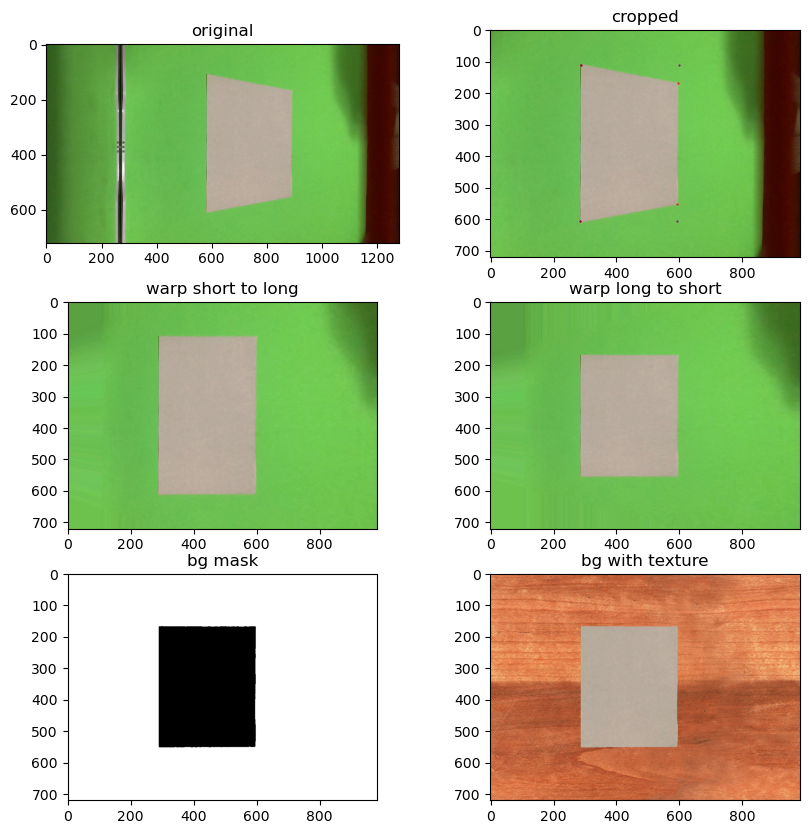

In [12]:
### old
align_img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad/0.jpg"
align_img = plt.imread(align_img_path)
print(align_img.shape, align_img.min(), align_img.max())

plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.imshow(align_img)
plt.title("original")

w_offset = 295
w_offset_max = -1
align_img = align_img[:,w_offset:w_offset_max]
plt.subplot(3,2,2)
plt.imshow(align_img)
plt.title("cropped")

# find label with terminal python
h1 = 109
h2 = 607
w1 = 583 - w_offset
w2 = 580 - w_offset

h3 = 168
w3 = 892 - w_offset
h4 = 551 
w4 = 889 - w_offset

corners = [
    [h1, w1],
    [h2, w2],
    [h3, w3],
    [h4, w4],
]
Y,X = list(zip(*corners))

plt.scatter(X,Y, marker=".", s=1, c="red")

gt_corners = [
    [h1, w1],
    [h2, w2],
    [h1, w3+1],
    [h2, w4-1],
]
gt_Y,gt_X = list(zip(*gt_corners))
plt.scatter(gt_X,gt_Y, marker=".", s=1, c="purple")


###
corners = np.array(corners)[:,::-1]
gt_corners = np.array(gt_corners)[:,::-1]
M, mask = cv2.findHomography(corners.astype(np.float32), gt_corners.astype(np.float32))
warp_img = cv2.warpPerspective(align_img, M, (align_img.shape[1], align_img.shape[0]), 
                           borderMode = cv2.BORDER_REPLICATE)
plt.subplot(3,2,3)
plt.imshow(warp_img)
plt.title("warp short to long")

gt_corners_2 = [
    [h3, w1-1],
    [h4, w2+1],
    [h3, w3],
    [h4, w4],
]
gt_corners_2 = np.array(gt_corners_2)[:,::-1]
M_2, mask = cv2.findHomography(corners.astype(np.float32), gt_corners_2.astype(np.float32))
warp_img = cv2.warpPerspective(align_img, M_2, (align_img.shape[1], align_img.shape[0]), 
                           borderMode = cv2.BORDER_REPLICATE)
plt.subplot(3,2,4)
plt.imshow(warp_img)
plt.title("warp long to short")

print(M, M_2)


warp_img_hsv = cv2.cvtColor(warp_img, cv2.COLOR_RGB2HSV_FULL)
hsv_mask = cv2.inRange(warp_img_hsv, 
                      (int(65/360*255), int(0.2*255), int(0.2*255)), 
                      (int(135/360*255),int(1*255), int(1*255)))
plt.subplot(3,2,5)
plt.imshow(hsv_mask,"gray")
plt.title("bg mask")

texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/texture_dataset/Pixar128 Library/wood/American_cherry_pxr128.tif"
texture_img = plt.imread(texture_path)
texture_img = cv2.resize(texture_img, align_img.shape[:2], interpolation=cv2.INTER_LANCZOS4)
texture_img = texture_img.transpose(1,0,2)
img_masked_w_text = align_img.copy()
img_masked_w_text[hsv_mask.astype(bool)] = texture_img[hsv_mask.astype(bool)]
plt.subplot(3,2,6)
plt.imshow(img_masked_w_text,)
plt.title("bg with texture")



(720, 1280, 3) 0 255


array([[ 8.42007494e-01, -1.25148841e-03, -5.52422633e+00],
       [-2.41678993e-01,  8.17786706e-01,  1.02995321e+02],
       [-6.13613411e-04, -8.50310493e-06,  1.00000000e+00]])

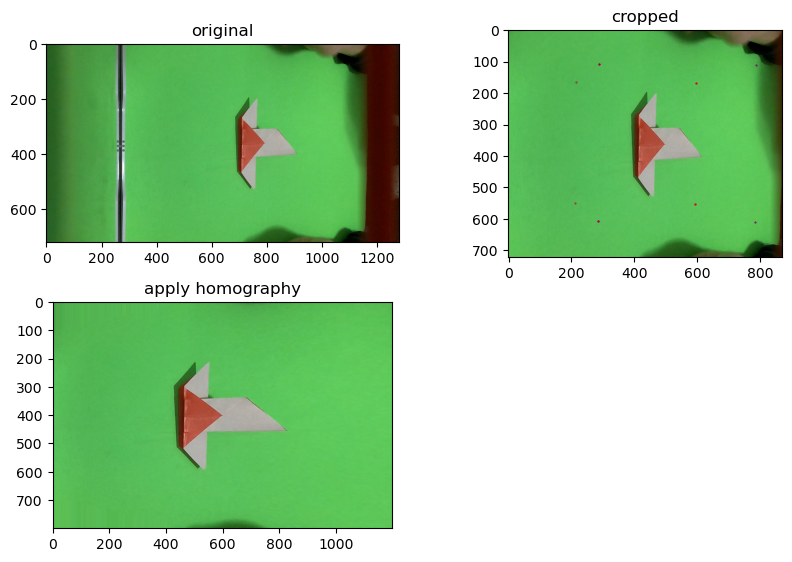

In [25]:
## fix homography
align_img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad/1482.jpg"
align_img = plt.imread(align_img_path)
print(align_img.shape, align_img.min(), align_img.max())

plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.imshow(align_img)
plt.title("original")

w_offset = 295
w_offset_max = 1165 # 1073
new_shape = (1200,800)
new_shape2 = (960,720)
align_img = align_img[:,w_offset:w_offset_max]
plt.subplot(3,2,2)
plt.imshow(align_img)
plt.title("cropped") 

# find the fixed coordinate of frame 0 with terminal python
h1 = 109 
h2 = 607
w1 = 583 - w_offset
w2 = 580 - w_offset

h3 = 168
w3 = 892 - w_offset
h4 = 551 
w4 = 889 - w_offset

corners = [
    [h1, w1],
    [h2, w2],
    [h3, w3],
    [h4, w4],
]
Y,X = list(zip(*corners))
plt.scatter(X,Y, marker=".", s=1, c="red")
corners = np.array(corners)[:,::-1]


# define target
gt_corners = [
    [h1, w1],
    [h2, w2],
    [h1 + (w1-w2), w1 + (h2-h1)],
    [h2 + (w1-w2), w2 + (h2-h1)],
]
gt_Y,gt_X = list(zip(*gt_corners))
plt.scatter(gt_X,gt_Y, marker=".", s=1, c="purple")
gt_corners = np.array(gt_corners)[:,::-1]
offset_from_shape = (new_shape[1] - align_img.shape[0])//2
gt_corners[:,1] += offset_from_shape

gt_corners_2 = [
    [h3 - (w3-w4), w3 - (h4-h3)],
    [h4 - (w3-w4), w4 - (h4-h3)],
    [h3, w3],
    [h4, w4],
]
gt_Y2,gt_X2 = list(zip(*gt_corners_2))
plt.scatter(gt_X2,gt_Y2, marker=".", s=1, c="brown")
gt_corners_2 = np.array(gt_corners_2)[:,::-1]

## map 1: short to long
M, mask = cv2.findHomography(corners.astype(np.float32), gt_corners.astype(np.float32))
# # calculate new size
# max_size = M @ np.array((align_img.shape[1], align_img.shape[0], 1))
# max_size = max_size[:2] / max_size[2]
# max_size = max_size.astype(int)
warp_img = cv2.warpPerspective(align_img, M, new_shape, 
                               flags=cv2.INTER_LANCZOS4,
                               borderMode = cv2.BORDER_REPLICATE)
plt.subplot(3,2,3)
plt.imshow(warp_img)
# plt.title("warp short to long")
plt.title("apply homography")

# ### map 2: long to short
# M_2, mask = cv2.findHomography(corners.astype(np.float32), gt_corners_2.astype(np.float32))

# warp_img2 = cv2.warpPerspective(align_img, M_2, new_shape2, 
#                            borderMode = cv2.BORDER_REPLICATE)
# plt.subplot(3,2,4)
# plt.imshow(warp_img2)
# plt.title("warp long to short")

display(M)
# display(M_2)
np.save("ipad_homography.npy", M)
# np.save("ipad_homography2.npy", M_2)



(720, 1280, 3) 0 255
shift in x  67


array([[ 8.63796163e-01, -1.40080094e-03,  5.42107452e+01],
       [-2.50120235e-01,  8.46349949e-01,  9.28360771e+01],
       [-6.35045392e-04, -8.80009709e-06,  1.00000000e+00]])

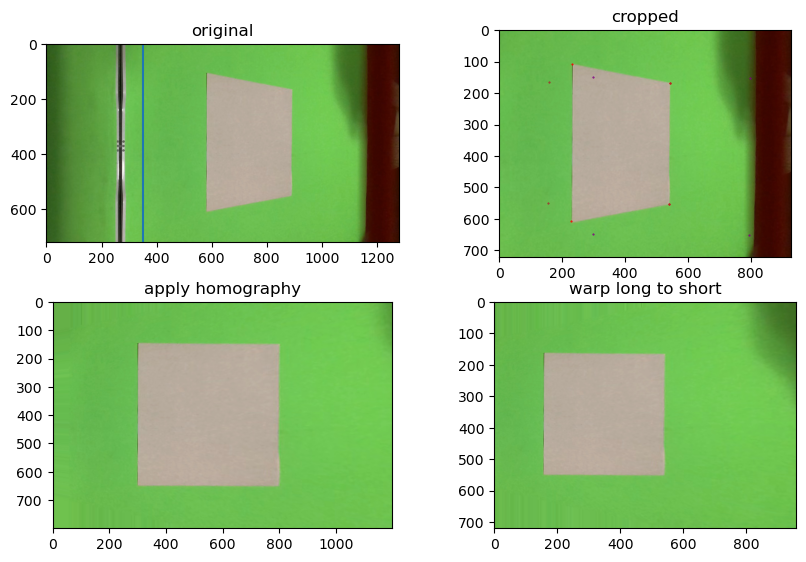

In [20]:
## new fix homography, 500px->15cm
align_img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project code/Code/data/22_0_ipad/0.jpg"
align_img = plt.imread(align_img_path)
print(align_img.shape, align_img.min(), align_img.max())

w_offset = 350
w_offset_max = 1280 # 1165

plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.imshow(align_img)
plt.plot([w_offset,w_offset], [0,720-1])
plt.title("original")


new_shape = (1200,800) # (1200,800)
new_shape2 = (960,720)
align_img = align_img[:,w_offset:w_offset_max]
plt.subplot(3,2,2)
plt.imshow(align_img)
plt.title("cropped") 

# find the fixed coordinate of frame 22_0_ipad/0.jpg with terminal python
h1 = 109 
h2 = 607
w1 = 583 - w_offset
w2 = 580 - w_offset

h3 = 168
w3 = 892 - w_offset
h4 = 551 
w4 = 889 - w_offset

corners = [
    [h1, w1],
    [h2, w2],
    [h3, w3],
    [h4, w4],
]
Y,X = list(zip(*corners))
plt.scatter(X,Y, marker=".", s=1, c="red")
corners = np.array(corners)[:,::-1]


# define target
gt_corners = [
    [h1, w1],
    [h2, w2],
    [h1 + (w1-w2), w1 + (h2-h1)],
    [h2 + (w1-w2), w2 + (h2-h1)],
]
gt_Y,gt_X = list(zip(*gt_corners))
# plt.scatter(gt_X,gt_Y, marker=".", s=1, c="purple")
gt_corners = np.array(gt_corners)[:,::-1]

gt_corners[:,1] += (new_shape[1] - align_img.shape[0])//2 # shift in y due to new height
print("shift in x ", (new_shape[0] - align_img.shape[1])//4)
gt_corners[:,0] += (new_shape[0] - align_img.shape[1])//4 # shift in x due to homography
plt.scatter(gt_corners[:,0],gt_corners[:,1], marker=".", s=1, c="purple")

gt_corners_2 = [
    [h3 - (w3-w4), w3 - (h4-h3)],
    [h4 - (w3-w4), w4 - (h4-h3)],
    [h3, w3],
    [h4, w4],
]
gt_Y2,gt_X2 = list(zip(*gt_corners_2))
plt.scatter(gt_X2,gt_Y2, marker=".", s=1, c="brown")
gt_corners_2 = np.array(gt_corners_2)[:,::-1]


## map 1: short to long
M, mask = cv2.findHomography(corners.astype(np.float32), gt_corners.astype(np.float32))
# # calculate new size
# max_size = M @ np.array((align_img.shape[1], align_img.shape[0], 1))
# max_size = max_size[:2] / max_size[2]
# max_size = max_size.astype(int)
warp_img = cv2.warpPerspective(align_img, M, new_shape, 
                               flags=cv2.INTER_LANCZOS4,
                               borderMode = cv2.BORDER_REPLICATE)
plt.subplot(3,2,3)
plt.imshow(warp_img)
# plt.title("warp short to long")
plt.title("apply homography")

# ### map 2: long to short
M_2, mask = cv2.findHomography(corners.astype(np.float32), gt_corners_2.astype(np.float32))

warp_img2 = cv2.warpPerspective(align_img, M_2, new_shape2, 
                           borderMode = cv2.BORDER_REPLICATE)
plt.subplot(3,2,4)
plt.imshow(warp_img2)
plt.title("warp long to short")

display(M)
# display(M_2)
# np.save("ipad_homography.npy", M)
# np.save("ipad_homography2.npy", M_2)



In [15]:
align_img.shape

(720, 815, 3)

### new dataset

(720, 1280, 3) 0 255


array([[ 9.06344204e-01, -8.11194431e-04, -1.27892548e+01],
       [-2.50120235e-01,  8.46349949e-01,  9.28360771e+01],
       [-6.35045392e-04, -8.80009709e-06,  1.00000000e+00]])

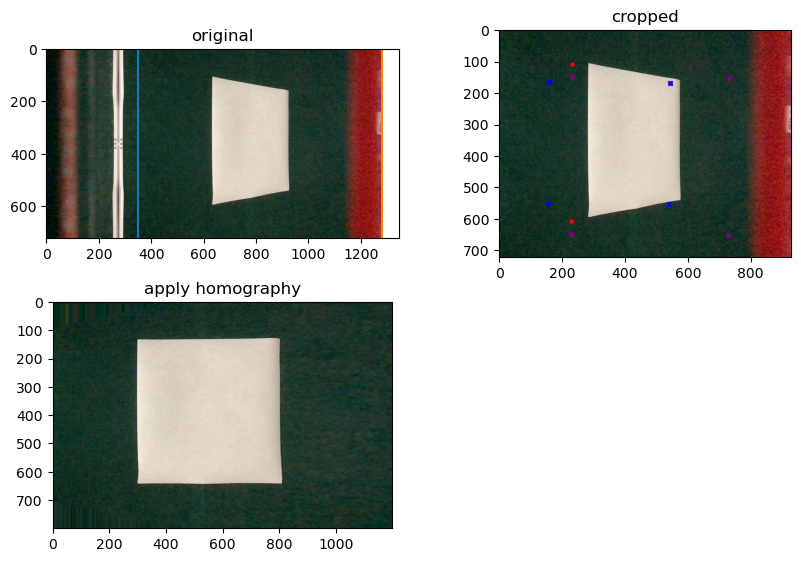

In [87]:
## new fix homography, 500px->15cm
align_img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/13.jpg"
align_img = plt.imread(align_img_path)
print(align_img.shape, align_img.min(), align_img.max())


w_offset = 350
w_offset_max = 1280 #1280 # 1165

plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.imshow(align_img)
plt.plot([w_offset,w_offset], [0,720-1]) # draw the line for w_offset
plt.plot([w_offset_max,w_offset_max], [0,720-1]) # draw the line for w_offset
plt.title("original")


new_shape = (1200,800) #x,y
new_shape2 = (960,720)
align_img = align_img[:,w_offset:w_offset_max]
plt.subplot(3,2,2)
plt.imshow(align_img)
plt.title("cropped") 

# find the fixed coordinate of frame 22_0_ipad/0.jpg with terminal python
h1 = 109 
h2 = 607
w1 = 583 - w_offset
w2 = 580 - w_offset

h3 = 168
w3 = 892 - w_offset
h4 = 551 
w4 = 889 - w_offset

corners = [
    [h1, w1],
    [h2, w2],
    [h3, w3],
    [h4, w4],
]
Y,X = list(zip(*corners))
plt.scatter(X,Y, marker=".", s=20, c="red")
corners = np.array(corners)[:,::-1]


# define target
gt_corners = [
    [h1, w1],
    [h2, w2],
    [h1 + (w1-w2), w1 + (h2-h1)],
    [h2 + (w1-w2), w2 + (h2-h1)],
]
gt_Y,gt_X = list(zip(*gt_corners))
# plt.scatter(gt_X,gt_Y, marker=".", s=1, c="purple")
gt_corners = np.array(gt_corners)[:,::-1]

gt_corners[:,1] += (new_shape[1] - align_img.shape[0])//2 # shift in y due to new height, to see more on the top/bottom margin
# print("shift in x ", (new_shape[0] - align_img.shape[1])//4)
# gt_corners[:,0] += (new_shape[0] - align_img.shape[1])//4 # shift in x due to homography
plt.scatter(gt_corners[:,0],gt_corners[:,1], marker="x", s=10, c="purple")

gt_corners_2 = [
    [h3 - (w3-w4), w3 - (h4-h3)],
    [h4 - (w3-w4), w4 - (h4-h3)],
    [h3, w3],
    [h4, w4],
]
gt_Y2,gt_X2 = list(zip(*gt_corners_2))
plt.scatter(gt_X2,gt_Y2, marker="x", s=10, c="blue")
gt_corners_2 = np.array(gt_corners_2)[:,::-1]


## map 1: short to long
M, mask = cv2.findHomography(corners.astype(np.float32), gt_corners.astype(np.float32))
warp_img = cv2.warpPerspective(align_img, M, new_shape, 
                               flags=cv2.INTER_LANCZOS4,
                               borderMode = cv2.BORDER_REPLICATE) # BORDER_CONSTANT)#
plt.subplot(3,2,3)
plt.imshow(warp_img)
# plt.title("warp short to long")
plt.title("apply homography")

# ### map 2: long to short
M_2, mask = cv2.findHomography(corners.astype(np.float32), gt_corners_2.astype(np.float32))

warp_img2 = cv2.warpPerspective(align_img, M_2, new_shape2, 
                           borderMode = cv2.BORDER_REPLICATE)
# plt.subplot(3,2,4)
# plt.imshow(warp_img2)
# plt.title("warp long to short")

display(M)
# display(M_2)
np.save("ipad_homography_new.npy", M)
# np.save("ipad_homography2.npy", M_2)



(720, 1280, 3) 0 255


array([[ 9.06344204e-01, -8.11194431e-04, -1.27892548e+01],
       [-2.50120235e-01,  8.46349949e-01,  9.28360771e+01],
       [-6.35045392e-04, -8.80009709e-06,  1.00000000e+00]])

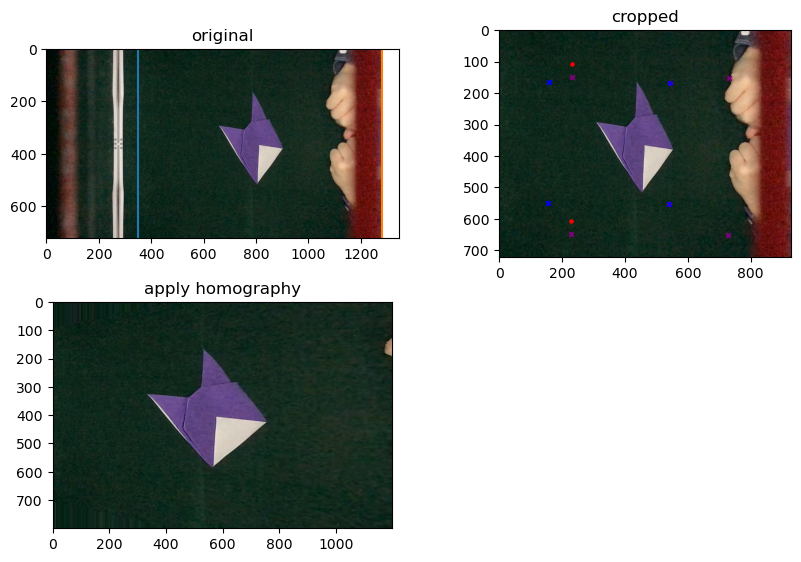

In [88]:
## check new fix homography
align_img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g/5150.jpg"
align_img = plt.imread(align_img_path)
print(align_img.shape, align_img.min(), align_img.max())


w_offset = 350
w_offset_max = 1280 #1280 # 1165

plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.imshow(align_img)
plt.plot([w_offset,w_offset], [0,720-1]) # draw the line for w_offset
plt.plot([w_offset_max,w_offset_max], [0,720-1]) # draw the line for w_offset
plt.title("original")


new_shape = (1200,800) #x,y
new_shape2 = (960,720)
align_img = align_img[:,w_offset:w_offset_max]
plt.subplot(3,2,2)
plt.imshow(align_img)
plt.title("cropped") 

# find the fixed coordinate of frame 22_0_ipad/0.jpg with terminal python
h1 = 109 
h2 = 607
w1 = 583 - w_offset
w2 = 580 - w_offset

h3 = 168
w3 = 892 - w_offset
h4 = 551 
w4 = 889 - w_offset

corners = [
    [h1, w1],
    [h2, w2],
    [h3, w3],
    [h4, w4],
]
Y,X = list(zip(*corners))
plt.scatter(X,Y, marker=".", s=20, c="red")
corners = np.array(corners)[:,::-1]


# define target
gt_corners = [
    [h1, w1],
    [h2, w2],
    [h1 + (w1-w2), w1 + (h2-h1)],
    [h2 + (w1-w2), w2 + (h2-h1)],
]
gt_Y,gt_X = list(zip(*gt_corners))
# plt.scatter(gt_X,gt_Y, marker=".", s=1, c="purple")
gt_corners = np.array(gt_corners)[:,::-1]

gt_corners[:,1] += (new_shape[1] - align_img.shape[0])//2 # shift in y due to new height
# print("shift in x ", (new_shape[0] - align_img.shape[1])//4)
# gt_corners[:,0] += (new_shape[0] - align_img.shape[1])//4 # shift in x due to homography
plt.scatter(gt_corners[:,0],gt_corners[:,1], marker="x", s=10, c="purple")

gt_corners_2 = [
    [h3 - (w3-w4), w3 - (h4-h3)],
    [h4 - (w3-w4), w4 - (h4-h3)],
    [h3, w3],
    [h4, w4],
]
gt_Y2,gt_X2 = list(zip(*gt_corners_2))
plt.scatter(gt_X2,gt_Y2, marker="x", s=10, c="blue")
gt_corners_2 = np.array(gt_corners_2)[:,::-1]


## map 1: short to long
M, mask = cv2.findHomography(corners.astype(np.float32), gt_corners.astype(np.float32))
warp_img = cv2.warpPerspective(align_img, M, new_shape, 
                               flags=cv2.INTER_LANCZOS4,
                               borderMode = cv2.BORDER_REPLICATE) # BORDER_CONSTANT)#
plt.subplot(3,2,3)
plt.imshow(warp_img)
# plt.title("warp short to long")
plt.title("apply homography")

# # ### map 2: long to short
# M_2, mask = cv2.findHomography(corners.astype(np.float32), gt_corners_2.astype(np.float32))

# warp_img2 = cv2.warpPerspective(align_img, M_2, new_shape2, 
#                            borderMode = cv2.BORDER_REPLICATE)
# plt.subplot(3,2,4)
# plt.imshow(warp_img2)
# plt.title("warp long to short")

display(M)
# display(M_2)
# np.save("ipad_homography.npy", M)
# np.save("ipad_homography2.npy", M_2)



In [57]:
## old process batch
# cropping var (fixed for each homography)
# w_offset = 295              ## offset width to crop
# w_offset_max = 1165 # 1073  
w_offset = 350
w_offset_max = 1280
new_shape = (1200,800)
homography = np.load("ipad_homography_new.npy")

def fix_homography(in_folder, out_folder):
    """ convert all img in in_folder """
    assert os.path.exists(in_folder)
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    
    for img_name in tqdm(os.listdir(in_folder)):
        if img_name.endswith(".npz") or img_name.endswith(".txt"):
            shutil.copy2(os.path.join(in_folder, img_name), 
                         os.path.join(out_folder, img_name))
            continue
        if not img_name.endswith(".jpg"):
            continue
        img = plt.imread(os.path.join(in_folder, img_name)) #[H,W,3]
        img = img[:,w_offset:w_offset_max]
        warp_img = cv2.warpPerspective(img, homography, new_shape, 
                                       flags=cv2.INTER_LANCZOS4,
                                       borderMode = cv2.BORDER_REPLICATE)
        warp_img = Image.fromarray(warp_img)
        warp_img.save(os.path.join(out_folder, img_name))
    print(f"Save img from {in_folder} to {out_folder}")

In [58]:
in_folder = "data/dog_p_on_g"
out_folder = "data/dog_p_on_g_homog"
fix_homography(in_folder, out_folder)

100%|███████████████████████████████████████| 5348/5348 [11:58<00:00,  7.45it/s]

Save img from data/dog_p_on_g to data/dog_p_on_g_homog


## Color Thresholding

### Color Background Thresholding

(720, 984, 3) 0 225
(720, 984, 3) 0 255


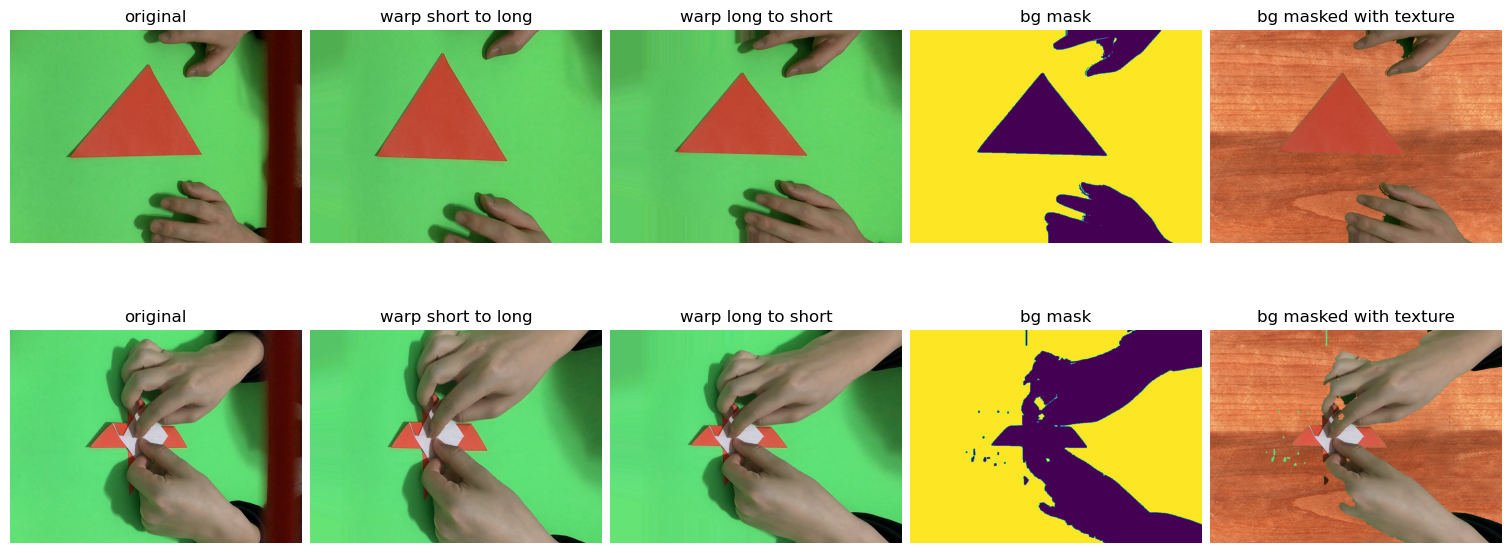

In [214]:
## old color threasjold
# try on intermediate image
img_list = []
titles = []

align_img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad/1000.jpg"
align_img = plt.imread(align_img_path)
w_offset = 295
w_offset_max = -1
align_img = align_img[:,w_offset:w_offset_max]
print(align_img.shape, align_img.min(), align_img.max())
img_list.append(align_img)
titles.append("original")

warp_img = cv2.warpPerspective(align_img, M, (align_img.shape[1], align_img.shape[0]), 
                               borderMode = cv2.BORDER_REPLICATE)
img_list.append(warp_img)
titles.append("warp short to long")

warp_img2 = cv2.warpPerspective(align_img, M_2, (align_img.shape[1], align_img.shape[0]), 
                           borderMode = cv2.BORDER_REPLICATE)
img_list.append(warp_img2)
titles.append("warp long to short")

warp_img_hsv = cv2.cvtColor(warp_img2, cv2.COLOR_RGB2HSV_FULL)
hsv_mask = cv2.inRange(warp_img_hsv, 
                      (int(65/360*255), int(0.2*255), int(0.2*255)), 
                      (int(135/360*255),int(1*255), int(1*255)))
img_list.append(hsv_mask)
titles.append("bg mask")

texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/Pixar128 Library/wood/American_cherry_pxr128.tif"
texture_img = plt.imread(texture_path)
texture_img = cv2.resize(texture_img, warp_img_hsv.shape[:2], interpolation=cv2.INTER_LANCZOS4)
texture_img = texture_img.transpose(1,0,2)
warp_img2_w_text = warp_img2.copy()
warp_img2_w_text[hsv_mask.astype(bool)] = texture_img[hsv_mask.astype(bool)]
img_list.append(warp_img2_w_text)
titles.append("bg masked with texture")



##
align_img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad/2500.jpg"
align_img = plt.imread(align_img_path)
w_offset = 295
w_offset_max = -1
align_img = align_img[:,w_offset:w_offset_max]

print(align_img.shape, align_img.min(), align_img.max())
img_list.append(align_img)
titles.append("original")

warp_img = cv2.warpPerspective(align_img, M, (align_img.shape[1], align_img.shape[0]), 
                               borderMode = cv2.BORDER_REPLICATE)
img_list.append(warp_img)
titles.append("warp short to long")

warp_img2 = cv2.warpPerspective(align_img, M_2, (align_img.shape[1], align_img.shape[0]), 
                           borderMode = cv2.BORDER_REPLICATE)
img_list.append(warp_img2)
titles.append("warp long to short")


warp_img_hsv = cv2.cvtColor(warp_img2, cv2.COLOR_RGB2HSV_FULL)
hsv_mask = cv2.inRange(warp_img_hsv, 
                      (int(65/360*255), int(0.2*255), int(0.2*255)), 
                      (int(135/360*255),int(1*255), int(1*255)))
hsv_mask = cv2.morphologyEx(hsv_mask, cv2.MORPH_CLOSE, kernel=np.ones((5,5),np.uint8))
img_list.append(hsv_mask)
titles.append("bg mask")

texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/Pixar128 Library/wood/American_cherry_pxr128.tif"
texture_img = plt.imread(texture_path)
texture_img = cv2.resize(texture_img, warp_img_hsv.shape[:2], interpolation=cv2.INTER_LANCZOS4)
texture_img = texture_img.transpose(1,0,2)
warp_img2_w_text = warp_img2.copy()
warp_img2_w_text[hsv_mask.astype(bool)] = texture_img[hsv_mask.astype(bool)]
img_list.append(warp_img2_w_text)
titles.append("bg masked with texture")


plot_np_image_grid(img_list, n_per_row=5, titles=titles, figsize=(15,6))

In [83]:
warp_img_hsv = cv2.cvtColor(warp_img, cv2.COLOR_RGB2HSV_FULL)
warp_img_hsv.shape

print_img_stats(warp_img_hsv[:,:,0],warp_img_hsv[:,:,1], warp_img_hsv[:,:,2])

(800, 1200) 0 255
(800, 1200) 17 255
(800, 1200) 6 235


(800, 1200) 0 250
(800, 1200) 0 254
(800, 1200) 0 255
(800, 1200) 0 255
(800, 1200) 0 255
(800, 1200) 1 255


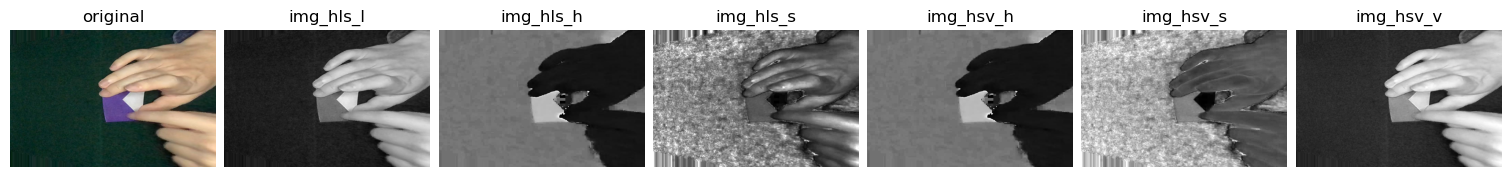

In [62]:
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_homog/5342.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_homog/82.jpg"
img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_homog/2714.jpg"
img = load_uint8_img(img_path) #/255).astype(np.float32)

img_list = [img]
gray = []
titles = ["original"]

# into HLS
img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS_FULL)
img_hls_l = img_hls[:,:,1]
img_list.append(img_hls_l)
gray.append(len(img_list)-1)
titles.append("img_hls_l")

img_hls_h = img_hls[:,:,0]
img_list.append(img_hls_h)
gray.append(len(img_list)-1)
titles.append("img_hls_h")

img_hls_s = img_hls[:,:,2]
img_list.append(img_hls_s)
gray.append(len(img_list)-1)
titles.append("img_hls_s")

# into HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL)
img_hsv_h = img_hsv[:,:,0]
img_list.append(img_hsv_h)
gray.append(len(img_list)-1)
titles.append("img_hsv_h")

img_hsv_s = img_hsv[:,:,1]
img_list.append(img_hsv_s)
gray.append(len(img_list)-1)
titles.append("img_hsv_s")

img_hsv_v = img_hsv[:,:,2]
img_list.append(img_hsv_v)
gray.append(len(img_list)-1)
titles.append("img_hsv_v")

plot_np_image_grid(img_list, n_per_row=7, titles=titles, gray=gray, figsize=(15,8))
print_img_stats(img_hls_l, img_hls_h, img_hls_s, img_hsv_h, img_hsv_s, img_hsv_v)
plt.show()

check hsv_h and hsv_v

In [66]:
print_img_stats(_img)

(800, 1200, 3) 0.0 0.9529412


In [72]:
np.max(img_hsv.reshape(-1,3), axis=0)

array([356.25     ,   0.9999995,   0.9529412], dtype=float32)

(800, 1200, 3) 0 255
0.5934322916666667
0.6067895833333333


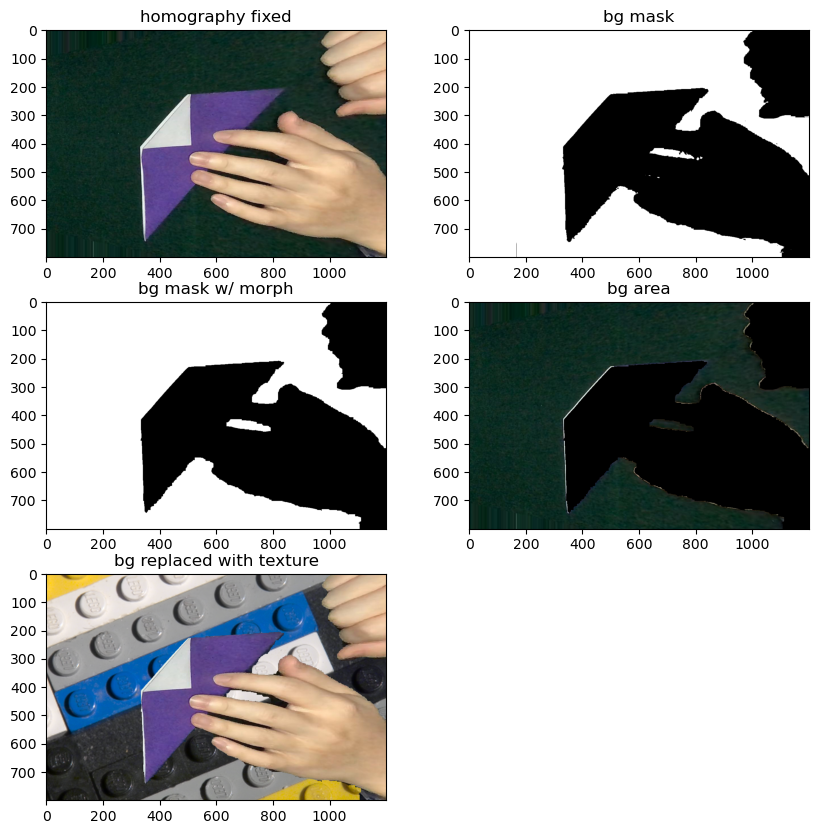

In [6]:
# color thresholding: https://colorizer.org
R,C = 3,2
plt.figure(figsize=(10,10))

# load cropped img
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_homog/82.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_homog/5342.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_homog/2714.jpg"
img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_homog/2177.jpg" 
img = plt.imread(img_path)
print_img_stats(img)
plt.subplot(R,C,1)
plt.imshow(img)
plt.title("homography fixed")

### define color filter
_img = (img / 255).astype(np.float32)
img_hsv = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL) # 0-360, 0-1, 0-1
# mask = cv2.inRange(img_hsv, 
#                       (85, 0.4, 0.1), 
#                       (165,1, 1))
mask = cv2.inRange(img_hsv, 
                      (75, 0., 0.), 
                      (200,1, 0.45))

# img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS_FULL)
# mask = cv2.inRange(img_hls, 
#                   (int(70/360*255), int(0.2*255), int(0.5*255)), 
#                   (int(150/360*255),int(0.8*255), int(1*255)))

mask = mask / 255
plt.subplot(R,C,2)
plt.imshow(mask,"gray")
plt.title("bg mask")
print(mask.mean())

# remove active noise in mask
kernel = np.ones((3,3),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=3)
# kernel = np.ones((3,3),np.uint8)
mask = cv2.dilate(mask, kernel, iterations=3)
plt.subplot(R,C,3)
plt.imshow(mask,"gray")
plt.title("bg mask w/ morph")
print(mask.mean())

# show bg area
img_bg = img.copy()
img_bg[~ mask.astype(bool)] = 0
plt.subplot(R,C,4)
plt.imshow(img_bg)
plt.title("bg area")

# load texture
# texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project Code/Code/data/texture_dataset/Pixar128 Library/wood/American_cherry_pxr128.tif"
texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project Code/Code/data/texture_dataset/Merged/146_c1l4r120.png"
texture_img = load_uint8_img(texture_path)
# texture_img = texture_img.transpose(1,0,2)
texture_img = cv2.resize(texture_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# show bg-replaced img
img_masked_w_text = img.copy()
img_masked_w_text[mask.astype(bool)] = texture_img[mask.astype(bool)]
plt.subplot(R,C,5)
plt.imshow(img_masked_w_text,)
plt.title("bg replaced with texture")

Image.fromarray(img_masked_w_text).save("temp2.jpg")


In [377]:
## process batch
# color thresholding var
def get_mask(img):
    _img = (img / 255).astype(np.float32)
    img_hsv = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL)
    ## 0
#     mask = cv2.inRange(img_hsv, 
#                           (95, 0.4, 0.1), 
#                           (150,1, 1))
    ## 1
#     mask = cv2.inRange(img_hsv, 
#                           (85, 0.4, 0.1), 
#                           (165,1, 1))
    mask = cv2.inRange(img_hsv, 
                      (75, 0., 0.), 
                      (200,1, 0.45))
    
    mask = mask / 255
    # remove active noise in mask
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=3)
    # kernel = np.ones((3,3),np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=3)

    return mask

def replace_bg(in_folder, out_folder, texture_img, output_size=None):
    """ convert all img in in_folder """
    assert os.path.exists(in_folder)
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    
    resize = True # for texture img
    for img_name in tqdm(os.listdir(in_folder)):
        if not img_name.endswith(".jpg"):
            if img_name == "label.txt":
                shutil.copy(os.path.join(in_folder, "label.txt"), out_folder)
            continue
        img = plt.imread(os.path.join(in_folder, img_name)).copy()
        mask = get_mask(img)
        if resize:
            texture_img = cv2.resize(texture_img, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)
            resize=False
        img[mask.astype(bool)] = texture_img[mask.astype(bool)]
        if output_size:
            img = cv2.resize(img, output_size, cv2.INTER_LANCZOS4)
        merge_img = Image.fromarray(img)
        merge_img.save(os.path.join(out_folder, img_name))
    print(f"Save img from {in_folder} to {out_folder}")

In [378]:
# texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/texture_dataset/Pixar128 Library/wood/American_cherry_pxr128.tif"
# texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/texture_dataset/Pixar128 Library/roof/Red_shingle_pxr128.tif"
texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/texture_dataset/Pixar128 Library/wood/Figured_yew_wood_pxr128.tif"

texture_img = load_uint8_img(texture_path)
# texture_img = cv2.resize(texture_img, (1200,800), interpolation=cv2.INTER_LANCZOS4)
# texture_img = cv2.resize(texture_img, (1920,1080), interpolation=cv2.INTER_LANCZOS4)

in_folder = "data/22_0_phone_pruned"
out_folder = "data/22_0_phone_pruned_bg2wood"
# in_folder = "data/22_1_ipad_homog"
# out_folder = "data/22_1_ipad_homog_bg2brick_"


# replace_bg(in_folder, out_folder, texture_img)
replace_bg(in_folder, out_folder, texture_img, (512,512))


100%|███████████████████████████████████████| 3243/3243 [15:34<00:00,  3.47it/s]

Save img from data/22_0_phone_pruned to data/22_0_phone_pruned_bg2wood


### fg color thresholding (bad effect)

(800, 1200, 3) 0 253
0.8463760416666667
0.857540625
0.0337875
0.033772916666666666
0.02105
0.020944791666666667


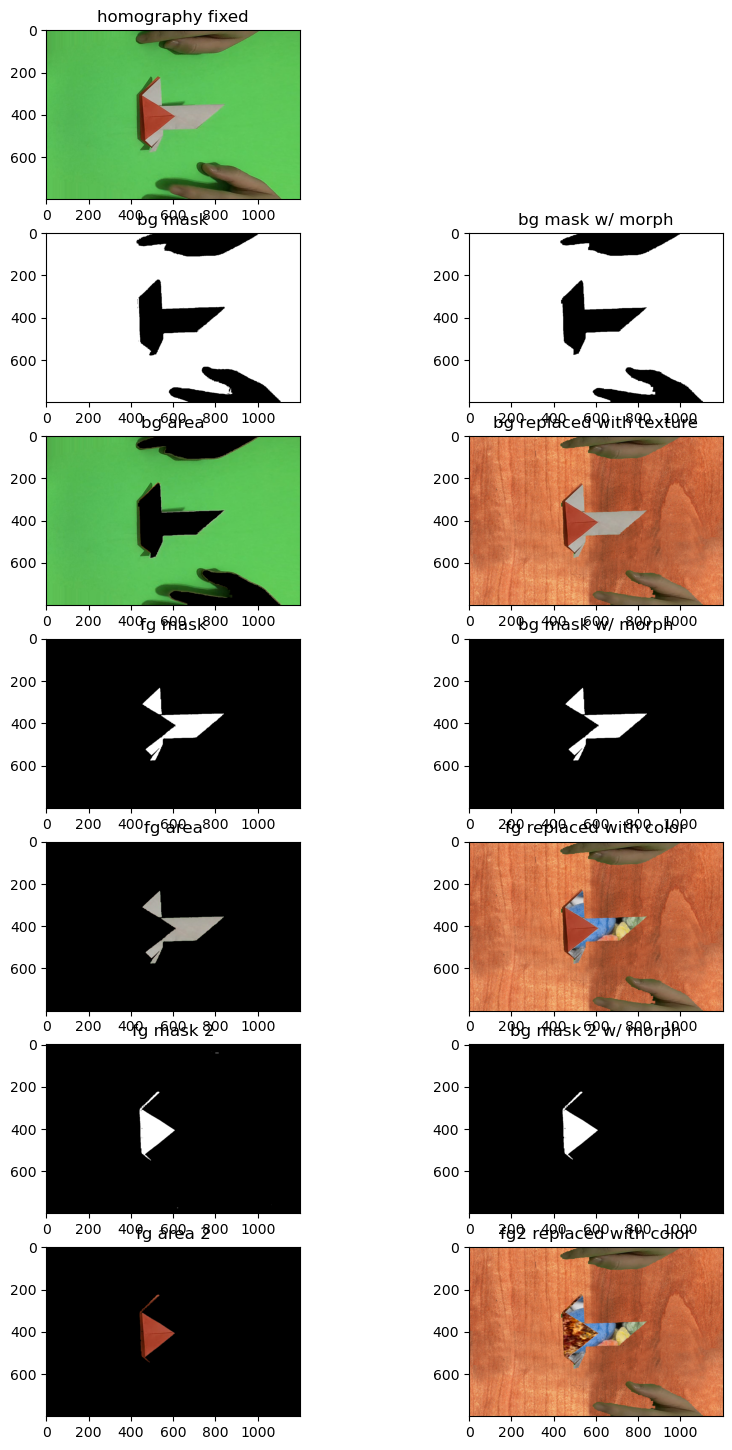

In [46]:
# color thresholding: https://colorizer.org
R,C,_c = 7,2,1
plt.figure(figsize=(10,18))

# load cropped img
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad_homog3/85.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad_homog3/1089.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad_homog3/1579.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad_homog3/2079.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad_homog3/2579.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad_homog/162.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad_homog/1.jpg"
img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad_homog/1711.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_phone_pruned/22.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_phone/1779.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_phone/9.jpg"
img = plt.imread(img_path)
print_img_stats(img)
plt.subplot(R,C,_c); _c+=2
plt.imshow(img)
plt.title("homography fixed")

### define color filter
# img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL)
# mask = cv2.inRange(img_hsv, 
#                       (int(95/360*255), int(0.4*255), int(0.1*255)), 
#                       (int(150/360*255),int(1*255), int(1*255)))

_img = (img / 255).astype(np.float32)
img_hsv = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL)
mask = cv2.inRange(img_hsv, 
                      (85, 0.4, 0.1), 
                      (165,1, 1))

mask = mask / 255
plt.subplot(R,C,_c); _c+=1
plt.imshow(mask,"gray")
plt.title("bg mask")
print(mask.mean())

# remove active noise in mask
kernel = np.ones((3,3),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=3)
# kernel = np.ones((3,3),np.uint8)
mask = cv2.dilate(mask, kernel, iterations=3)
plt.subplot(R,C,_c); _c+=1
plt.imshow(mask,"gray")
plt.title("bg mask w/ morph")
print(mask.mean())

# show bg area
img_bg = img.copy()
img_bg[~ mask.astype(bool)] = 0
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_bg)
plt.title("bg area")

# load texture
texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/texture_dataset/Pixar128 Library/wood/American_cherry_pxr128.tif"
texture_img = load_uint8_img(texture_path)
# texture_img = texture_img.transpose(1,0,2)
texture_img = cv2.resize(texture_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# show bg-replaced img
img_masked_w_text = img.copy()
img_masked_w_text[mask.astype(bool)] = texture_img[mask.astype(bool)]
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_masked_w_text,)
plt.title("bg replaced with texture")

# fg mask
img_hsv = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL)
fg_mask = cv2.inRange(img_hsv, 
                  (0, 0, 0.55), 
                  (360,0.20, 1))

fg_mask = fg_mask / 255
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask,"gray")
plt.title("fg mask")
print(fg_mask.mean())

# remove active noise in mask
kernel = np.ones((3,3),np.uint8)
fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=1)
# kernel = np.ones((3,3),np.uint8)
# fg_mask = cv2.dilate(fg_mask, kernel, iterations=3)
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask,"gray")
plt.title("bg mask w/ morph")
print(fg_mask.mean())

# show fg area
img_fg = img.copy()
img_fg[~ fg_mask.astype(bool)] = 0
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_fg)
plt.title("fg area")

# load fg texture
fg_texture_path = "data/texture_dataset/Merged/213_c1l8r180.png"
fg_texture_img = load_uint8_img(fg_texture_path)
# fg_texture_img = (np.clip(fg_texture_img, 0, 1) * 255).astype(np.uint8)
fg_texture_img = cv2.resize(fg_texture_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# show bg-replaced img
img_masked_w_text_fg_change = img.copy()
# img_masked_w_text_fg_change[fg_mask.astype(bool)] = list(np.random.choice(range(256), size=3)) #[255,255,255]
img_masked_w_text_fg_change[fg_mask.astype(bool)] = fg_texture_img[fg_mask.astype(bool)]
img_masked_w_text_fg_change[mask.astype(bool)] = texture_img[mask.astype(bool)]

plt.subplot(R,C,_c); _c+=1
plt.imshow(img_masked_w_text_fg_change)
plt.title("fg replaced with color")

# fg mask 2: red
img_hsv2 = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL)
img_hsv2[:,:,0][ img_hsv2[:,:,0] < 180] += 360 #[180,540]
img_hsv2[:,:,0] -= 180
fg_mask2 = cv2.inRange(img_hsv2, 
                      (170, 0.4, 0.1), 
                      (200,1, 1))

fg_mask2 = fg_mask2 / 255
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask2,"gray")
plt.title("fg mask 2")
print(fg_mask2.mean())

# remove active noise in mask2
kernel = np.ones((3,3),np.uint8)
fg_mask2 = cv2.morphologyEx(fg_mask2, cv2.MORPH_OPEN, kernel, iterations=1)
# kernel = np.ones((3,3),np.uint8)
# fg_mask = cv2.dilate(fg_mask, kernel, iterations=3)
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask2,"gray")
plt.title("bg mask 2 w/ morph")
print(fg_mask2.mean())

# show fg area 2
img_fg = img.copy()
img_fg[~ fg_mask2.astype(bool)] = 0
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_fg)
plt.title("fg area 2")

# load fg texture 2
fg_texture_path2 = "data/texture_dataset/Merged/Paintings.11.0003.ppm"
fg_texture_img2 = load_uint8_img(fg_texture_path2)
# fg_texture_img2 = (np.clip(fg_texture_img2, 0, 1) * 255).astype(np.uint8)
fg_texture_img2 = cv2.resize(fg_texture_img2, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# show bg-replaced img 2
img_masked_w_text_fg_change = img.copy()
# img_masked_w_text_fg_change[fg_mask.astype(bool)] = list(np.random.choice(range(256), size=3)) #[255,255,255]
img_masked_w_text_fg_change[fg_mask.astype(bool)] = fg_texture_img[fg_mask.astype(bool)]
img_masked_w_text_fg_change[fg_mask2.astype(bool)] = fg_texture_img2[fg_mask2.astype(bool)]
img_masked_w_text_fg_change[mask.astype(bool)] = texture_img[mask.astype(bool)]

plt.subplot(R,C,_c); _c+=1
plt.imshow(img_masked_w_text_fg_change)
plt.title("fg2 replaced with color")

plt.show()

# plt.imshow(img)
# plt.show()
# plt.imshow(img_masked_w_text_fg_change)
# plt.show()
# Image.fromarray(img_masked_w_text_fg_change).save("temp2.jpg")


In [338]:
fg_texture_path2 = "data/texture_dataset/Merged/Paintings.11.0003.ppm"
fg_texture_img2 = plt.imread(fg_texture_path2)
print_img_stats(fg_texture_img2)

(512, 512, 3) 0 255


(800, 1200, 3) 0 255
0.8592197916666666
0.03408958333333333
0.03934791666666667


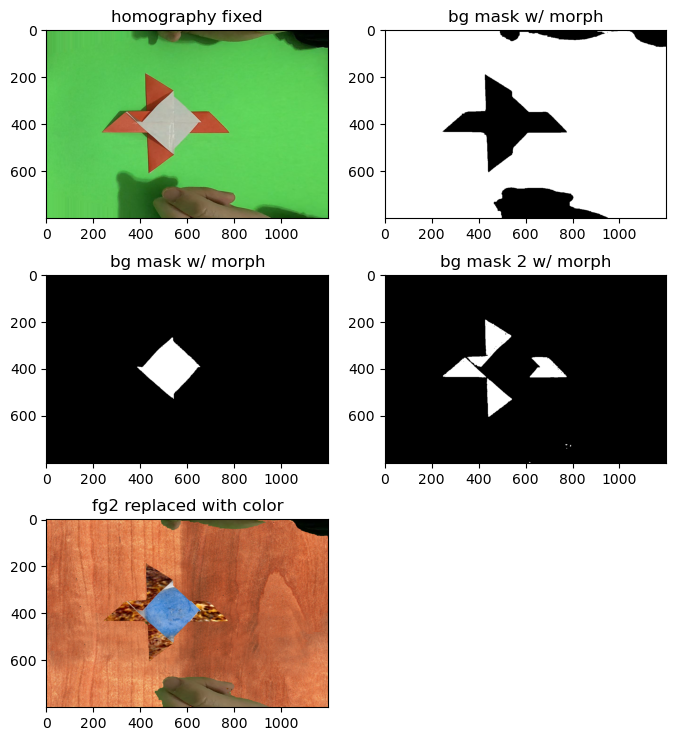

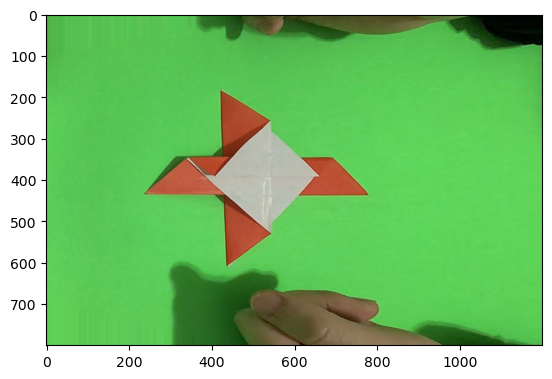

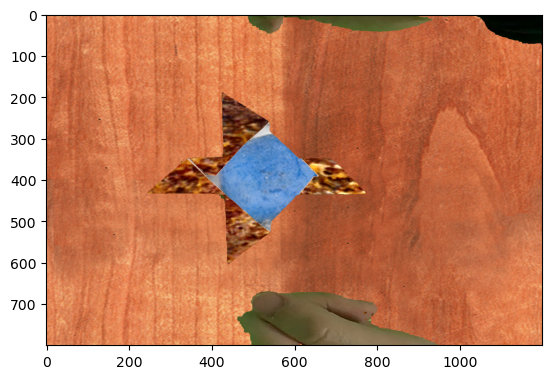

In [66]:
## better visualization
# color thresholding: https://colorizer.org
R,C,_c = 3,2,1
plt.figure(figsize=(8,9))

# load cropped img
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad_homog/85.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad_homog/1089.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad_homog/1579.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad_homog/2079.jpg"
img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_ipad_homog/2579.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad_homog/162.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad_homog/1.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad_homog/1711.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_0_phone_pruned/22.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_phone/1779.jpg"
# img_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_phone/9.jpg"
img = plt.imread(img_path)
print_img_stats(img)
plt.subplot(R,C,_c); _c+=1
plt.imshow(img)
plt.title("homography fixed")

### define color filter
# img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL)
# mask = cv2.inRange(img_hsv, 
#                       (int(95/360*255), int(0.4*255), int(0.1*255)), 
#                       (int(150/360*255),int(1*255), int(1*255)))

_img = (img / 255).astype(np.float32)
img_hsv = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL)
mask = cv2.inRange(img_hsv, 
                      (85, 0.4, 0.1), 
                      (165,1, 1))

mask = mask / 255
# remove active noise in mask
kernel = np.ones((3,3),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=3)
# kernel = np.ones((3,3),np.uint8)
mask = cv2.dilate(mask, kernel, iterations=3)
plt.subplot(R,C,_c); _c+=1
plt.imshow(mask,"gray")
plt.title("bg mask w/ morph")
print(mask.mean())

# load texture
texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/texture_dataset/Pixar128 Library/wood/American_cherry_pxr128.tif"
texture_img = load_uint8_img(texture_path)
# texture_img = texture_img.transpose(1,0,2)
texture_img = cv2.resize(texture_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)


# fg mask
img_hsv = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL)
fg_mask = cv2.inRange(img_hsv, 
                  (0, 0, 0.55), 
                  (360,0.20, 1))

fg_mask = fg_mask / 255
# remove active noise in mask
kernel = np.ones((3,3),np.uint8)
fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=1)
# kernel = np.ones((3,3),np.uint8)
# fg_mask = cv2.dilate(fg_mask, kernel, iterations=3)
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask,"gray")
plt.title("bg mask w/ morph")
print(fg_mask.mean())

# load fg texture
fg_texture_path = "data/texture_dataset/Merged/213_c1l8r180.png"
fg_texture_img = load_uint8_img(fg_texture_path)
# fg_texture_img = (np.clip(fg_texture_img, 0, 1) * 255).astype(np.uint8)
fg_texture_img = cv2.resize(fg_texture_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)


# fg mask 2: red
img_hsv2 = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL)
img_hsv2[:,:,0][ img_hsv2[:,:,0] < 180] += 360 #[180,540]
img_hsv2[:,:,0] -= 180
fg_mask2 = cv2.inRange(img_hsv2, 
                      (170, 0.4, 0.1), 
                      (200,1, 1))

fg_mask2 = fg_mask2 / 255
# remove active noise in mask2
kernel = np.ones((3,3),np.uint8)
fg_mask2 = cv2.morphologyEx(fg_mask2, cv2.MORPH_OPEN, kernel, iterations=1)
# kernel = np.ones((3,3),np.uint8)
# fg_mask = cv2.dilate(fg_mask, kernel, iterations=3)
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask2,"gray")
plt.title("bg mask 2 w/ morph")
print(fg_mask2.mean())


# load fg texture 2
fg_texture_path2 = "data/texture_dataset/Merged/Paintings.11.0003.ppm"
fg_texture_img2 = load_uint8_img(fg_texture_path2)
# fg_texture_img2 = (np.clip(fg_texture_img2, 0, 1) * 255).astype(np.uint8)
fg_texture_img2 = cv2.resize(fg_texture_img2, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# show bg-replaced img 2
img_masked_w_text_fg_change = img.copy()
# img_masked_w_text_fg_change[fg_mask.astype(bool)] = list(np.random.choice(range(256), size=3)) #[255,255,255]
img_masked_w_text_fg_change[fg_mask.astype(bool)] = fg_texture_img[fg_mask.astype(bool)]
img_masked_w_text_fg_change[fg_mask2.astype(bool)] = fg_texture_img2[fg_mask2.astype(bool)]
img_masked_w_text_fg_change[mask.astype(bool)] = texture_img[mask.astype(bool)]

plt.subplot(R,C,_c); _c+=1
plt.imshow(img_masked_w_text_fg_change)
plt.title("fg2 replaced with color")

plt.show()

plt.imshow(img)
plt.show()
plt.imshow(img_masked_w_text_fg_change)
plt.show()
# Image.fromarray(img_masked_w_text_fg_change).save("temp2.jpg")



### fg color thresholding for detection

(800, 1200, 3) 0 255
0.5955947916666666
0.604621875
0.002103125
0.0012708333333333332
0.010726041666666667
0.010232291666666667


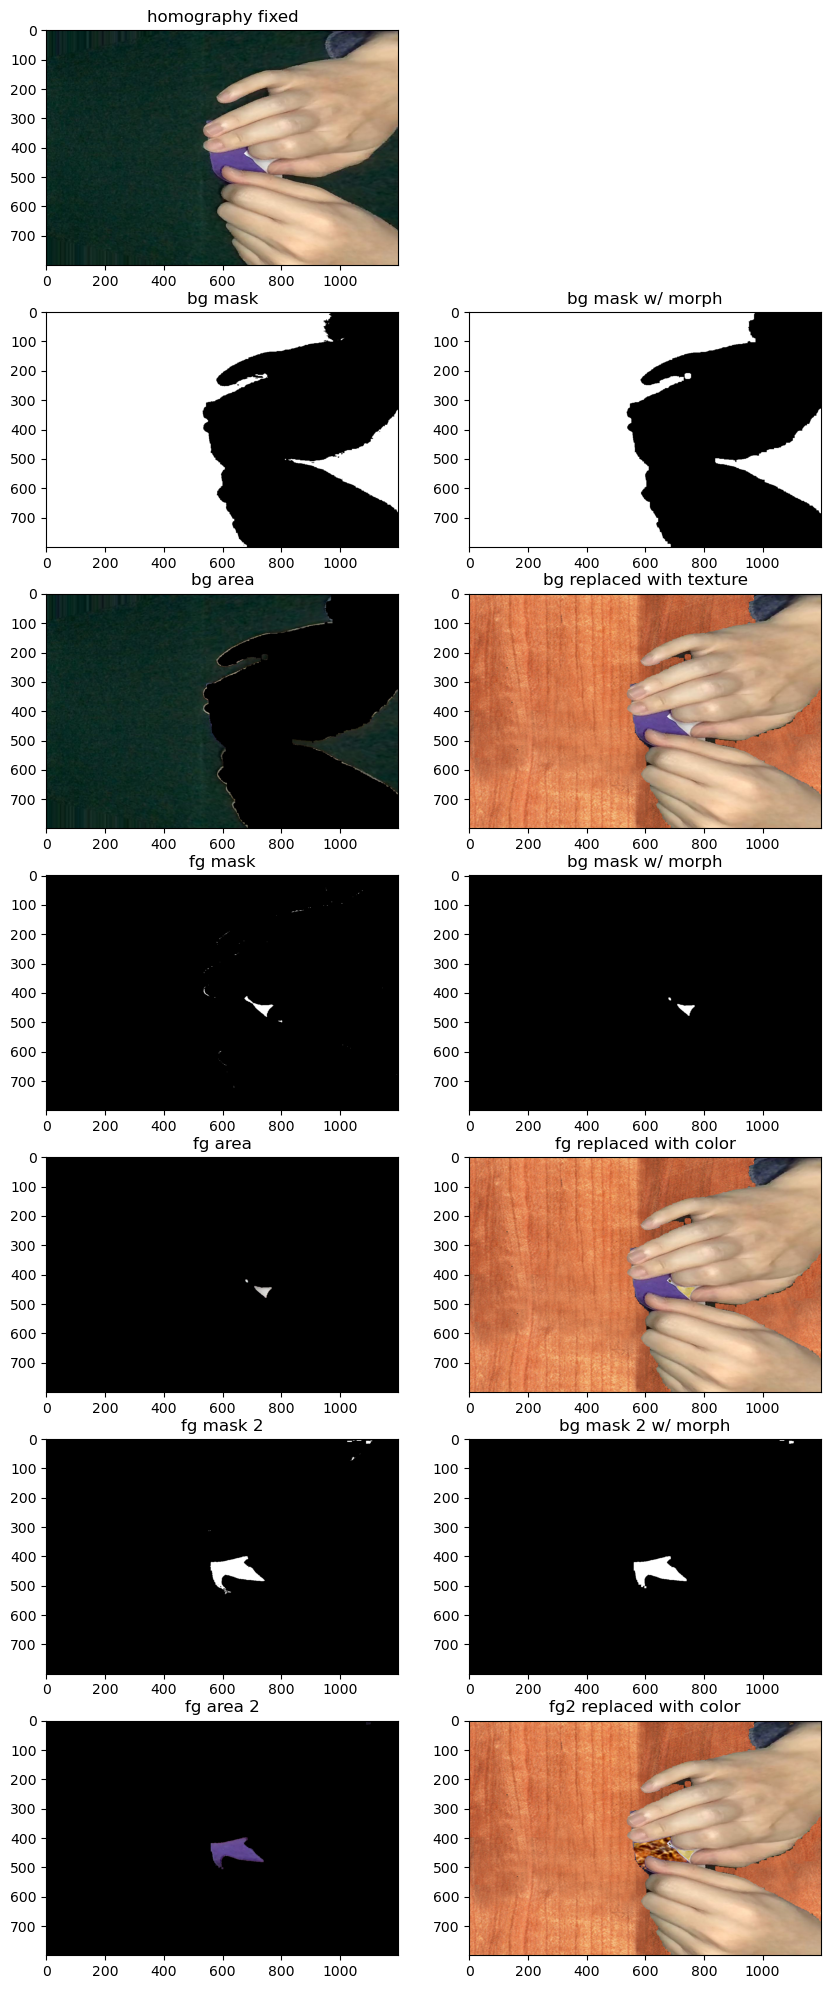

In [21]:
# color thresholding: https://colorizer.org
R,C,_c = 7,2,1
plt.figure(figsize=(10,25))

# load cropped img
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/5342.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/2714.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/1215.jpg"
img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/2691.jpg"
# img_path = "/Users/jameschen/Desktop/16622 MSCV Capston/Code/data/dog_p_on_g_anno_homog/3244.jpg"

img = plt.imread(img_path)
print_img_stats(img)
plt.subplot(R,C,_c); _c+=2
plt.imshow(img)
plt.title("homography fixed")

############################ background mask
### define color filter
_img = (img / 255).astype(np.float32)
img_hsv = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL) # 0-360, 0-1, 0-1
mask = cv2.inRange(img_hsv, 
                      (75, 0., 0.), 
                      (200,1, 0.45))
mask = mask / 255
plt.subplot(R,C,_c); _c+=1
plt.imshow(mask,"gray")
plt.title("bg mask")
print(mask.mean())

# remove active noise in mask
kernel = np.ones((3,3),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=3)
# kernel = np.ones((3,3),np.uint8)
mask = cv2.dilate(mask, kernel, iterations=3)
plt.subplot(R,C,_c); _c+=1
plt.imshow(mask,"gray")
plt.title("bg mask w/ morph")
print(mask.mean())

# show bg area
img_bg = img.copy()
img_bg[~ mask.astype(bool)] = 0
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_bg)
plt.title("bg area")

# load texture
texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project code/Code/data/texture_dataset/Pixar128 Library/wood/American_cherry_pxr128.tif"
texture_img = load_uint8_img(texture_path)
# texture_img = texture_img.transpose(1,0,2)
texture_img = cv2.resize(texture_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# show bg-replaced img
img_masked_w_text = img.copy()
img_masked_w_text[mask.astype(bool)] = texture_img[mask.astype(bool)]
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_masked_w_text,)
plt.title("bg replaced with texture")
############################ 

############################ foreground mask for white part
# fg mask
img_hsv = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL) # 0-360, 0-1, 0-1
fg_mask = cv2.inRange(img_hsv,  (0,  0, 0.55), 
                                (360,0.14, 1))
fg_mask = fg_mask / 255
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask,"gray")
plt.title("fg mask")
print(fg_mask.mean())

# remove active noise in mask
kernel = np.ones((3,3),np.uint8)
fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=3)
# kernel = np.ones((3,3),np.uint8)
fg_mask = cv2.erode(fg_mask, kernel, iterations=1)
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask,"gray")
plt.title("bg mask w/ morph")
print(fg_mask.mean())

# show fg area
img_fg = img.copy()
img_fg[~ fg_mask.astype(bool)] = 0
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_fg)
plt.title("fg area")

# load fg texture
fg_texture_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project code/Code/data/texture_dataset/Merged/213_c1l8r180.png"
fg_texture_img = load_uint8_img(fg_texture_path)
# fg_texture_img = (np.clip(fg_texture_img, 0, 1) * 255).astype(np.uint8)
fg_texture_img = cv2.resize(fg_texture_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# show bg-replaced img
img_masked_w_text_fg_change = img.copy()
# img_masked_w_text_fg_change[fg_mask.astype(bool)] = list(np.random.choice(range(256), size=3)) #[255,255,255]
img_masked_w_text_fg_change[fg_mask.astype(bool)] = fg_texture_img[fg_mask.astype(bool)]
img_masked_w_text_fg_change[mask.astype(bool)] = texture_img[mask.astype(bool)]

plt.subplot(R,C,_c); _c+=1
plt.imshow(img_masked_w_text_fg_change)
plt.title("fg replaced with color")
############################



# ############################ foreground mask for white part 2 
# ##(using lightness itself from HLS is not enough, as it will mask out hands as well)
# # fg mask
# img_hls = cv2.cvtColor(_img, cv2.COLOR_RGB2HLS_FULL) # 0-360, 0-1, 0-1
# fg_mask = cv2.inRange(img_hls,  (0,  0.8, 0), 
#                                 (360,1., 1))
# fg_mask = fg_mask / 255
# plt.subplot(R,C,_c); _c+=1
# plt.imshow(fg_mask,"gray")
# plt.title("fg mask hsl (lightness)")
# print(fg_mask.mean())

# # remove active noise in mask
# kernel = np.ones((3,3),np.uint8)
# fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=1)
# # kernel = np.ones((3,3),np.uint8)
# # fg_mask = cv2.dilate(fg_mask, kernel, iterations=3)
# plt.subplot(R,C,_c); _c+=1
# plt.imshow(fg_mask,"gray")
# plt.title("bg mask w/ morph")
# print(fg_mask.mean())
# ############################


############################ foreground mask for color part
# fg mask 2: purple
img_hsv2 = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV_FULL) # 0-360, 0-1, 0-1
fg_mask2 = cv2.inRange(img_hsv2, 
                      (250, 0.3, 0.1), 
                      (310, 1, 0.95))

fg_mask2 = fg_mask2 / 255
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask2,"gray")
plt.title("fg mask 2")
print(fg_mask2.mean())

# remove active noise in mask2
kernel = np.ones((3,3),np.uint8)
fg_mask2 = cv2.morphologyEx(fg_mask2, cv2.MORPH_OPEN, kernel, iterations=3)
# kernel = np.ones((3,3),np.uint8)
fg_mask = cv2.erode(fg_mask, kernel, iterations=1)
plt.subplot(R,C,_c); _c+=1
plt.imshow(fg_mask2,"gray")
plt.title("bg mask 2 w/ morph")
print(fg_mask2.mean())

# show fg area 2
img_fg = img.copy()
img_fg[~ fg_mask2.astype(bool)] = 0
plt.subplot(R,C,_c); _c+=1
plt.imshow(img_fg)
plt.title("fg area 2")

# load fg texture 2
fg_texture_path2 = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project code/Code/data/texture_dataset/Merged/Paintings.11.0003.ppm"
fg_texture_img2 = load_uint8_img(fg_texture_path2)
fg_texture_img2 = cv2.resize(fg_texture_img2, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# show bg-replaced img 2
img_masked_w_text_fg_change = img.copy()
# img_masked_w_text_fg_change[fg_mask.astype(bool)] = list(np.random.choice(range(256), size=3)) #[255,255,255]
img_masked_w_text_fg_change[fg_mask.astype(bool)] = fg_texture_img[fg_mask.astype(bool)]
img_masked_w_text_fg_change[fg_mask2.astype(bool)] = fg_texture_img2[fg_mask2.astype(bool)]
img_masked_w_text_fg_change[mask.astype(bool)] = texture_img[mask.astype(bool)]

plt.subplot(R,C,_c); _c+=1
plt.imshow(img_masked_w_text_fg_change)
plt.title("fg2 replaced with color")
############################

plt.show()
# Image.fromarray(img_masked_w_text_fg_change).save("temp2.jpg")

In [22]:
img_hls = cv2.cvtColor(_img, cv2.COLOR_RGB2HLS_FULL) 
print_img_stats(img_hls[:,:,0],img_hls[:,:,1],img_hls[:,:,2])

(800, 1200) 0.0 358.92856
(800, 1200) 0.0019607844 0.9882353
(800, 1200) 0.0 1.0000012
